本脚本研究如何通过关键点匹配技术，来对齐关键点

In [1]:
# read code tools
# share in https://gist.github.com/WuShaogui/19c690bde2a0fe70b061d50e20129531
import sys
import os.path as osp
sys.path.append('/home/wushaogui/ReadCode/')
from my_read_code_tools import *

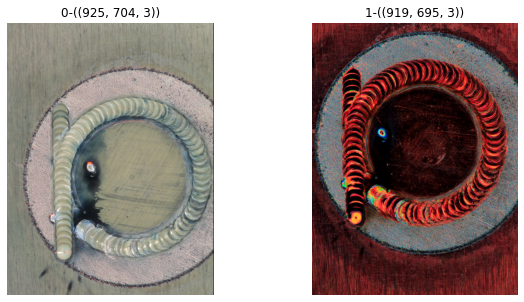

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('/home/wushaogui/ReadCode/Test/关键点匹配与仿射变换/pic1.png')
# queryImage
img2 = cv2.imread('/home/wushaogui/ReadCode/Test/关键点匹配与仿射变换/pic2.png')  # trainImage

show_images([img1,img2[...,::-1]])

In [3]:
gray1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

[ WARN:0] global /tmp/pip-req-build-vrhoqk3o/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [4]:
# Apply ratio test
# 比值测试，首先获取与 A距离最近的点 B （最近）和 C （次近），
# 只有当 B/C 小于阀值时（0.75）才被认为是匹配，
# 因为假设匹配是一一对应的，真正的匹配的理想距离为0
good = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good.append([m])

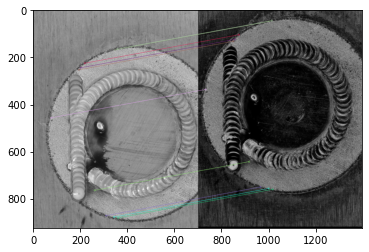

(<matplotlib.image.AxesImage at 0x7ff988742850>, None)

In [5]:
# cv2.drawMatchesKnn expects list of lists as matches.
gray = np.ndarray([2, 2])
gray = cv2.drawMatchesKnn(gray1, kp1, gray2, kp2, good[:10], gray, flags=2)

# cv2.drawMatchesKnn expects list of lists as matches.
# gray3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,good,None,flags=2)

plt.imshow(gray), plt.show()

In [6]:
pts1=[]
pts2=[]
idxs = list(range(len(good)))
np.random.shuffle(idxs)

# for idx in range(len(matches)):
for idx in idxs[:3]: # 收集3个点计算仿射变换矩阵
    trainIdx=good[idx][0].trainIdx
    queryIdx=good[idx][0].queryIdx

    train_keypoint=kp1[queryIdx]
    query_keypoint=kp2[trainIdx]
    
    pts1.append(list(train_keypoint.pt))
    pts2.append(list(query_keypoint.pt))

[[ 1.00130110e+00  2.96642264e-03 -4.88021745e+01]
 [ 3.17297632e-03  1.00256755e+00 -1.21864641e+02]]


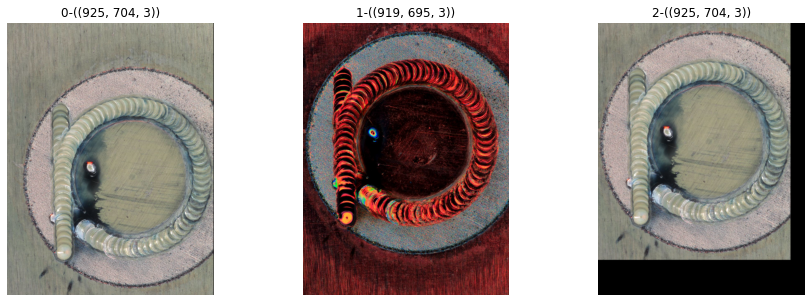

In [7]:
rows, cols, ch = img1.shape
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

M = cv2.getAffineTransform(pts1, pts2)
print(M)
if M[0][1]>0.5 or M[1][0]>0.5:
    print('仿射矩阵出现旋转')
else:
    M[0][1]=0
    M[1][0]=0
dst = cv2.warpAffine(img1, M, (cols, rows))

show_images([img1,img2[...,::-1],dst])

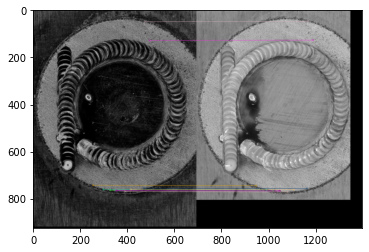

(<matplotlib.image.AxesImage at 0x7ff990047f90>, None)

In [8]:
gray3=cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()


# find the keypoints and descriptors with SIFT
kp2, des2 = sift.detectAndCompute(gray2, None)
kp3, des3 = sift.detectAndCompute(gray3, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des2, des3, k=2)

# Apply ratio test
# 比值测试，首先获取与 A距离最近的点 B （最近）和 C （次近），
# 只有当 B/C 小于阀值时（0.75）才被认为是匹配，
# 因为假设匹配是一一对应的，真正的匹配的理想距离为0
good = []
for m, n in matches:
    if m.distance < 0.45 * n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
gray = np.ndarray([2, 2])
gray = cv2.drawMatchesKnn(gray2, kp2, gray3, kp3, good[:10], gray, flags=2)

# cv2.drawMatchesKnn expects list of lists as matches.
# gray3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,good,None,flags=2)

plt.imshow(gray), plt.show()